

# Recommendation System
- 1. Content based filtering
: 사용자가 특정한 아이템을 매우 선호하는 경우, 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템을 추천   
ex) 사용자가 특정 영화에 높은 평점 -> 그 영화의 장르, 배우, 감독, 키워드 등의 콘텐츠와 유사한 다른 영화를 추천  
- 2. Collaborative filtering :
  
 1) Nearest Neighbor Collaborative: 사용자가 아이템에 매긴 평점 정보나 상품 구매 이력과 같은 사용자 행동 양식만을 기반으로 추천  
 사용자-아이템 평점 matrix와 같은 축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템을 Predicted Rating 한다.
user - user: 특정 사용자와 타 사용자 간의 유사도 측정한 뒤, 가장 유사도가 높은 Nearest N 사용자를 추출해 그들이 사용하는 아이템을 추천 
item - item: 여러 사용자들이 그 아이템을 좋아하는지/싫어하는지의 평가 척도가 유사한 아이템을 추천
(pg, 562, 563 그림 참고)    
  
 2) Latent Factor Collaborative: 사용자-아이템 평점 매트릭스 속에 숨어 있는 잠재 요인(Latent Factor)을 추출해 추천  
 행렬 분해(Matrix Factorization) 방법을 이용한다.  
 1. "잠재 요인"을 기반으로 희소 행렬인 사용자 - 아이템 데이터를 밀집 행렬의 사용자-잠재요인 행렬과 아이템-잠재요인 행렬로 분해  
 2. 분해된 두 행렬의 내적을 통해 새로운 예측 사용자-아이템 평점 행렬 데이터를 만들어 아직 평점을 부여하지 않은 아이템에 예측 평점을 생성

Matrix Factorization (Latent Factor Collaborative) 기법이 온라인 시장에서 주로 사용됨 
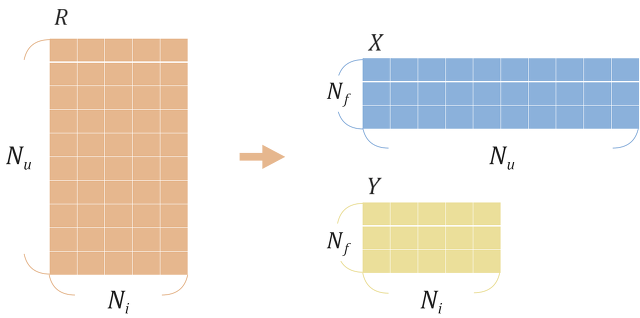


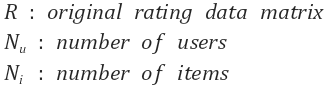

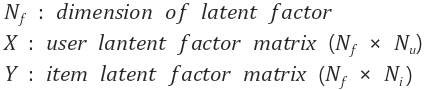

Nf는 Matrix Factorization 학습 시에 정하는 임의의 차원 수입니다.

개발자가 조정 가능하며 보통 50에서 200 사이로 설정합니다.  

X와 Y는 사용자와 아이템의 Latent Factor 행렬을 나타내며, 우리가 학습시키고자 하는 대상입니다.  

이 행렬들의 값은 아주 작은 랜덤한 값들로 초기화됩니다.  
  
    
    
  
    
      
        
        

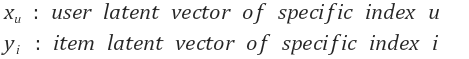

xu 와 yi는 각각 특정 사용자와 특정 아이템의 특징 벡터를 나타냅니다.

여기서 벡터는 1차원 어레이를 뜻하며, xu와 yi는 각각 Nf x 1 크기의 열 벡터 (column vector)로 볼 수 있습니다.

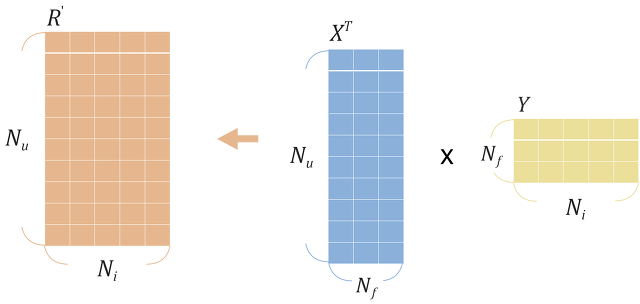

X 행렬의 전치 행렬 (Transpose)를 구하면 Nu x Nf 크기의 행렬이 됩니다.

이를 Y 행렬과 곱해주어 Nu x Ni 크기의 평점 예측 행렬을 구합니다.

예측된 하나의 평점 행렬의 각각의 값들은 다음과 같은 곱셈을 통해서 계산됩니다.







그래서 X transpose, Y는 어떻게 구하는가? (책에서는 Q transpose, P)

-> SGD(경사하강법) 이용 

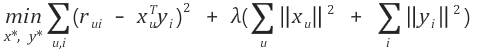
  를 만족하는 X, Y 찾기.

1. X, Y 를 임의의 값을 가진 행렬로 설정한다.
2. Y, X.transpose를 곱해(내적) 예측 R'을 계싼하고 실제 R행렬에 대한 오류 값을 계산한다.
3. 이 오류 값을 최소화할 수 있도록 X와 Y 행렬을 적절한 값으로 각각 업데이트 한다. (pg.570)
4. 만족할 만한 (작은) (loss function)오류 값을 가질 때까지 2,3 번 작업을 반복하면서 X와 Y값을 업데이트해 근사화한다.

In [3]:
import numpy as np
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN],
             [np.NaN, 5, np.NaN, 3, 1],
             [np.NaN, np.NaN, 3, 4, 4],
             [5, 2, 1, 2, np.NaN]]) #원본행렬 R 생성
num_users, num_items = R.shape 
K = 3 # Latent Factor Dim

np.random.seed(1)
P = np.random.normal(scale = 1./K, size = (num_users, K))
Q = np.random.normal(scale = 1./K, size = (num_items, K)) # P,Q를 scale 표준편차의 정규분포를 가진 임의의 값으로 설정
print(P)

[[ 0.54144845 -0.2039188  -0.17605725]
 [-0.35765621  0.28846921 -0.76717957]
 [ 0.58160392 -0.25373563  0.10634637]
 [-0.08312346  0.48736931 -0.68671357]]


In [4]:
from sklearn.metrics import mean_squared_error

def get_rmse(R,P,Q,non_zeros): # 원본 R행렬과 예측 행렬간 오차 계산
    error = 0
    #두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P,Q.T)
    
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse= np.sqrt(mse)
    
    return rmse

In [5]:
non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j]>0]
steps = 1000
learning_rate = 0.01
r_lambda = 0.01

for step in range(steps):
    for i, j, r in non_zeros:
        eij = r - np.dot(P[i,:],Q[j,:].T) #P는 사용자-잠재 요인 Q는 잠재요인-item
        P[i,:] = P[i,:] + learning_rate * (eij * Q[j,:] - r_lambda*P[i,:])
        Q[j,:] = Q[j,:] + learning_rate * (eij * P[i,:] - r_lambda*Q[j,:])
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 50) == 0 :
            print("### iteration step : ", step, "rmse : ", rmse)

### iteration step :  0 rmse :  3.261355059488935
### iteration step :  0 rmse :  3.26040057174686
### iteration step :  0 rmse :  3.253984404542389
### iteration step :  0 rmse :  3.2521583839863624
### iteration step :  0 rmse :  3.252335303789125
### iteration step :  0 rmse :  3.251072196430487
### iteration step :  0 rmse :  3.2492449982564864
### iteration step :  0 rmse :  3.247416477570409
### iteration step :  0 rmse :  3.241926055455223
### iteration step :  0 rmse :  3.2400454107613084
### iteration step :  0 rmse :  3.240166740749792
### iteration step :  0 rmse :  3.2388050277987723
### iteration step :  50 rmse :  0.5003190892212748
### iteration step :  50 rmse :  0.5001616291326989
### iteration step :  50 rmse :  0.49899601202578087
### iteration step :  50 rmse :  0.4988483450145829
### iteration step :  50 rmse :  0.4989518925663175
### iteration step :  50 rmse :  0.4983323683009099
### iteration step :  50 rmse :  0.4984148489378701
### iteration step :  50 rmse : 

### iteration step :  650 rmse :  0.016674291334806215
### iteration step :  650 rmse :  0.016782895588885044
### iteration step :  650 rmse :  0.01664569809164778
### iteration step :  650 rmse :  0.01656714079916238
### iteration step :  650 rmse :  0.016680091021598627
### iteration step :  650 rmse :  0.01669855427143079
### iteration step :  650 rmse :  0.016511017732427944
### iteration step :  650 rmse :  0.01649122876690526
### iteration step :  650 rmse :  0.01618054419796171
### iteration step :  650 rmse :  0.016311111507075402
### iteration step :  650 rmse :  0.016393167720500815
### iteration step :  650 rmse :  0.01664473691247672
### iteration step :  700 rmse :  0.016638362442608575
### iteration step :  700 rmse :  0.01674193674332361
### iteration step :  700 rmse :  0.01660352418900164
### iteration step :  700 rmse :  0.01652645439330055
### iteration step :  700 rmse :  0.01663979208337954
### iteration step :  700 rmse :  0.01665720134529739
### iteration step : 

In [6]:
pred_matrix = np.dot(P,Q.T)
print("원본 행렬:\n",R)
print('예측 행렬:\n', np.round(pred_matrix, 3))

원본 행렬:
 [[ 4. nan nan  2. nan]
 [nan  5. nan  3.  1.]
 [nan nan  3.  4.  4.]
 [ 5.  2.  1.  2. nan]]
예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]


In [7]:
print(non_zeros)

[(0, 0, 4.0), (0, 3, 2.0), (1, 1, 5.0), (1, 3, 3.0), (1, 4, 1.0), (2, 2, 3.0), (2, 3, 4.0), (2, 4, 4.0), (3, 0, 5.0), (3, 1, 2.0), (3, 2, 1.0), (3, 3, 2.0)]
